# Import Tools

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
torch.manual_seed(42)
np.random.seed(42)
from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data load

In [2]:
expression_data = pd.read_csv('../TCGA-SARC.star_tpm.tsv', sep='\t', index_col=0)  # Gene expression (TPM)
methylation_data = pd.read_csv('../TCGA-SARC.methylation450.tsv', sep='\t', index_col=0)  # DNA methylation
copy_number_data = pd.read_csv('../TCGA-SARC.gene-level_ascat3.tsv', sep='\t', index_col=0) # Copy number variations

try:
    phenotype_data = pd.read_csv('../TCGA-SARC.clinical.tsv', sep='\t', index_col=0)
except Exception as e:
    print("Error while loading phenotype_data:", e)
    with open('../TCGA-SARC.clinical.tsv', 'r') as f:
        for i, line in enumerate(f):
            try:
                pd.read_csv(pd.compat.StringIO(line), sep='\t')
            except Exception as row_e:
                print(f"Error in line {i}: {row_e}")
    phenotype_data = pd.read_csv('../TCGA-SARC.clinical.tsv', sep='\t', index_col=0, on_bad_lines='skip')

print("Data shapes:")
print(f"Expression data: {expression_data.shape}")
print(f"Methylation data: {methylation_data.shape}")
print(f"Copy number data: {copy_number_data.shape}")
print(f"Phenotype data: {phenotype_data.shape}")

Data shapes:
Expression data: (60660, 265)
Methylation data: (486427, 269)
Copy number data: (60623, 252)
Phenotype data: (272, 78)


# Sample Matching

In [3]:
print("Checking for missing values in phenotype data:")
missing_values = phenotype_data.isnull().sum()
print(missing_values[missing_values > 0])

print()
print("Checking sample overlap between different omics data:")

samples_expression = set(expression_data.columns)
samples_methylation = set(methylation_data.columns)
samples_cnv = set(copy_number_data.columns)
samples_clinical = set(phenotype_data.index)
print("Sample overlap:")
print(f"Expression samples: {len(samples_expression)}")
print(f"Methylation samples: {len(samples_methylation)}")
print(f"CNV samples: {len(samples_cnv)}")
print(f"Clinical samples: {len(samples_clinical)}")

# Find common samples across all omics
common_samples = list(samples_expression.intersection(samples_methylation, samples_cnv, samples_clinical))
print(f"Common samples across all omics: {len(common_samples)}")

# Filter data to keep only common samples
expression_data = expression_data[common_samples]
methylation_data = methylation_data[common_samples]
copy_number_data = copy_number_data[common_samples]
phenotype_data = phenotype_data.loc[common_samples]



Checking for missing values in phenotype data:
days_to_birth.demographic                                      1
year_of_birth.demographic                                      4
days_to_death.demographic                                    170
year_of_death.demographic                                    195
entity_submitter_id.annotations                              254
notes.annotations                                            254
submitter_id.annotations                                     254
classification.annotations                                   254
entity_id.annotations                                        254
created_datetime.annotations                                 254
annotation_id.annotations                                    254
entity_type.annotations                                      254
updated_datetime.annotations                                 254
case_id.annotations                                          254
state.annotations                          

# Data preprocessing

### Check Null value

In [4]:
#Check for null values of expression data
print("Checking for null values in expression data:")
null_expression = expression_data.isnull().sum().sum()
if null_expression > 0:
    print(f"Expression data contains {null_expression} null values.")
else:   
    print("No null values found in expression data.")
print()


# Check for null values in methylation data
print("Checking for null values in methylation data:")
null_methylation = methylation_data.isnull().sum().sum()
if null_methylation > 0:
    print(f"Methylation data contains {null_methylation} null values.")
else:
    print("No null values found in methylation data.")
print()


# Check for null values in copy number data
print("Checking for null values in copy number data:")
null_copy_number = copy_number_data.isnull().sum().sum()
if null_copy_number > 0:
    print(f"Copy number data contains {null_copy_number} null values.")
else:
    print("No null values found in copy number data.")
max_value = copy_number_data.max().max()
min_value = copy_number_data.min().min()

print(f"Maximum CNV value: {max_value}")
print(f"Minimum CNV value: {min_value}")
print()


# Check for null values in phenotype data
print("Checking for null values in phenotype data:")
null_phenotype = phenotype_data.isnull().sum().sum()
if null_phenotype > 0:
    print(f"Phenotype data contains {null_phenotype} null values.")
else:
    print("No null values found in phenotype data.")



Checking for null values in expression data:
No null values found in expression data.

Checking for null values in methylation data:
Methylation data contains 19949611 null values.

Checking for null values in copy number data:
Copy number data contains 202624 null values.
Maximum CNV value: 154.0
Minimum CNV value: 0.0

Checking for null values in phenotype data:
Phenotype data contains 3960 null values.


### Process data

In [5]:
# expression data preprocessing -------------------------------------------------->

# Log2 transform
expression_data_log = np.log2(expression_data + 1)

# Z-score standardization
scaler_expr = StandardScaler()
expression_data_scaled = pd.DataFrame(
    scaler_expr.fit_transform(expression_data_log.T).T,
    index=expression_data_log.index,
    columns=expression_data_log.columns
)

from sklearn.feature_selection import VarianceThreshold


# Methylation data preprocessing -------------------------------------------------->

# Droping probes with more than 25% missing values 
methylation_data = methylation_data.dropna(thresh=0.75 * methylation_data.shape[1], axis=0)
# DO NOT fill na for MOFA
# methylation_data = methylation_data.apply(lambda x: x.fillna(x.median()), axis=1)

# Remove low-variance methylation probes
selector = VarianceThreshold(threshold=0.01)
methylation_filtered = pd.DataFrame(
    selector.fit_transform(methylation_data.T).T,
    index=methylation_data.index[selector.get_support()],
    columns=methylation_data.columns
)

# Z-score standardization
scaler_meth = StandardScaler()
methylation_scaled = pd.DataFrame(
    scaler_meth.fit_transform(methylation_filtered.T).T,
    index=methylation_filtered.index,
    columns=methylation_filtered.columns
)


# Copy number data preprocessing -------------------------------------------------->

# Drop genes with >20% missing values
gene_missing_threshold = 0.2
copy_number_data_filtered = copy_number_data.loc[
    copy_number_data.isnull().mean(axis=1) < gene_missing_threshold
]
# Cap values to biologically plausible range
copy_number_imputed = copy_number_data_filtered
cnv_clipped = copy_number_data_filtered.clip(lower=0, upper=6)
log_cnv = np.log2(cnv_clipped / 2)
copy_number_scaled = log_cnv.loc[log_cnv.std(axis=1) > 0.2]

f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [6]:
# Phenotype data preprocessing -------------------------------------------------->
subtype_column = 'primary_diagnosis.diagnoses'
print(f"Using '{subtype_column}' as the subtype column")
print(f"Subtype distribution:\n{phenotype_data[subtype_column].value_counts()}")
print()
# Only keep selected subtypes
selected_subtypes = [
    'Leiomyosarcoma, NOS',
    'Dedifferentiated liposarcoma',
    'Undifferentiated sarcoma',
    'Fibromyxosarcoma'
 ]
phenotype_data = phenotype_data[phenotype_data[subtype_column].isin(selected_subtypes)]
print(f"Filtered to selected subtypes. Remaining samples: {len(phenotype_data)}")
# Checking missing values in the subtype column
missing_subtypes = phenotype_data[subtype_column].isnull().sum()
print(f"Missing values in subtype column: {missing_subtypes}")
if missing_subtypes > 0:
    phenotype_data_clean = phenotype_data.dropna(subset=[subtype_column])
    print(f"Removed {missing_subtypes} samples with missing subtypes")
    print(f"Remaining samples: {len(phenotype_data_clean)}")
else:
    phenotype_data_clean = phenotype_data.copy()
    print("No missing subtypes found")

Using 'primary_diagnosis.diagnoses' as the subtype column
Subtype distribution:
primary_diagnosis.diagnoses
Leiomyosarcoma, NOS                        100
Dedifferentiated liposarcoma                54
Undifferentiated sarcoma                    32
Fibromyxosarcoma                            24
Malignant fibrous histiocytoma              11
Malignant peripheral nerve sheath tumor      9
Synovial sarcoma, spindle cell               5
Myxoid leiomyosarcoma                        3
Giant cell sarcoma                           3
Synovial sarcoma, biphasic                   2
Synovial sarcoma, NOS                        2
Pleomorphic liposarcoma                      2
Abdominal fibromatosis                       1
Aggressive fibromatosis                      1
Liposarcoma, well differentiated             1
Name: count, dtype: int64

Filtered to selected subtypes. Remaining samples: 210
Missing values in subtype column: 0
No missing subtypes found


### Sample matching

In [7]:
# Extract subtypes for the common samples
subtypes = phenotype_data_clean[subtype_column]
# Encode subtypes as numeric labels
label_encoder = LabelEncoder()
subtype_encoded = label_encoder.fit_transform(subtypes)
# Create mapping to encode subtype classes
subtype_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"\nSubtype encoding mapping:")
for subtype, encoded in subtype_mapping.items():
    print(f"  {encoded}: {subtype}")
# Converted to pandas Series to easily handle the index
subtype_encoded = pd.Series(subtype_encoded, index=subtypes.index, name='subtype_encoded')
print(f"\nEncoded subtype distribution:")
print(subtype_encoded.value_counts().sort_index())
# Update common samples with available subtypes
valid_samples = list(set(common_samples).intersection(set(phenotype_data_clean.index)))
print(f"\nUpdating common samples from {len(common_samples)} to {len(valid_samples)} (removed samples with missing subtypes or not in selected subtypes)")
expression_data_scaled = expression_data_scaled[valid_samples]
methylation_scaled = methylation_scaled[valid_samples]
copy_number_scaled = copy_number_scaled[valid_samples]
subtype_encoded = subtype_encoded.loc[valid_samples]
common_samples = valid_samples
print()
print(f"Final data shapes after phenotype preprocessing:")
print(f"  Expression: {expression_data_scaled.shape}")
print(f"  Methylation: {methylation_scaled.shape}")
print(f"  Copy number: {copy_number_scaled.shape}")
print(f"  Phenotype: {phenotype_data_clean.shape}")
print(f"  Subtypes: {len(subtype_encoded)}")
print(f"  Common samples: {len(common_samples)}")


Subtype encoding mapping:
  0: Dedifferentiated liposarcoma
  1: Fibromyxosarcoma
  2: Leiomyosarcoma, NOS
  3: Undifferentiated sarcoma

Encoded subtype distribution:
subtype_encoded
0     54
1     24
2    100
3     32
Name: count, dtype: int64

Updating common samples from 250 to 210 (removed samples with missing subtypes or not in selected subtypes)

Final data shapes after phenotype preprocessing:
  Expression: (60660, 210)
  Methylation: (221087, 210)
  Copy number: (55930, 210)
  Phenotype: (210, 78)
  Subtypes: 210
  Common samples: 210


In [ ]:
# Save processed datasets for reproducibility
# expression_data_scaled.to_csv("../Updated_model_nd_dataset/expression_data_scaled_FXS_MOFA_3Omics.csv")
# methylation_scaled.to_csv("../Updated_model_nd_dataset/methylation_scaled_FXS_MOFA_3Omics.csv")
# copy_number_scaled.to_csv("../Updated_model_nd_dataset/copy_number_scaled_FXS_MOFA_3Omics.csv")
# subtype_encoded.to_csv("../Updated_model_nd_dataset/subtype_encoded_FXS_MOFA_3Omics.csv")
# phenotype_data_clean.to_csv("../Updated_model_nd_dataset/phenotype_data_clean_FXS_MOFA_3Omics.csv")

In [8]:
print("Expression:", expression_data_scaled.shape)
print("Methylation:", methylation_scaled.shape)
print("Copy Number:", copy_number_scaled.shape)
print("Phenotype:", phenotype_data_clean.shape)
print("Subtype labels:", subtype_encoded.shape)
print("Common samples:", len(common_samples))

Expression: (60660, 210)
Methylation: (221087, 210)
Copy Number: (55930, 210)
Phenotype: (210, 78)
Subtype labels: (210,)
Common samples: 210


In [9]:
from mofapy2.run.entry_point import entry_point

data_list = [
    [expression_data_scaled.T.values],   # view 0, group 0
    [methylation_scaled.T.values],       # view 1, group 0
    [copy_number_scaled.T.values]       # view 2, group 0
]

# Initialise MOFA
ent = entry_point()
ent.set_data_options(scale_views=False)
ent.set_data_matrix(data_list)

ent.set_model_options(
    factors=16,
    spikeslab_weights=True,
    ard_factors=True,
    ard_weights=True
)

# Training options
ent.set_train_options(
    iter=25,
    convergence_mode="medium",
    seed=42,
    verbose=True
)

# Build and run
ent.build()
ent.run()

# Extract results
factors = ent.model.nodes["Z"].getExpectation()
weights = ent.model.nodes["W"].getExpectation()



f:\BRACU\Thesis Thingy[T2510589]\DATASET 2\.venv\Lib\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
View names not provided, using default naming convention:
- view1, view2, ..., viewM

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group

In [10]:
print("Factors shape",factors.shape)
print("Weights shape (view0):", weights[0].shape)
print("Weights shape (view1):", weights[1].shape)
print("Weights shape (view2):", weights[2].shape)


Factors shape (210, 16)
Weights shape (view0): (60660, 16)
Weights shape (view1): (221087, 16)
Weights shape (view2): (55930, 16)


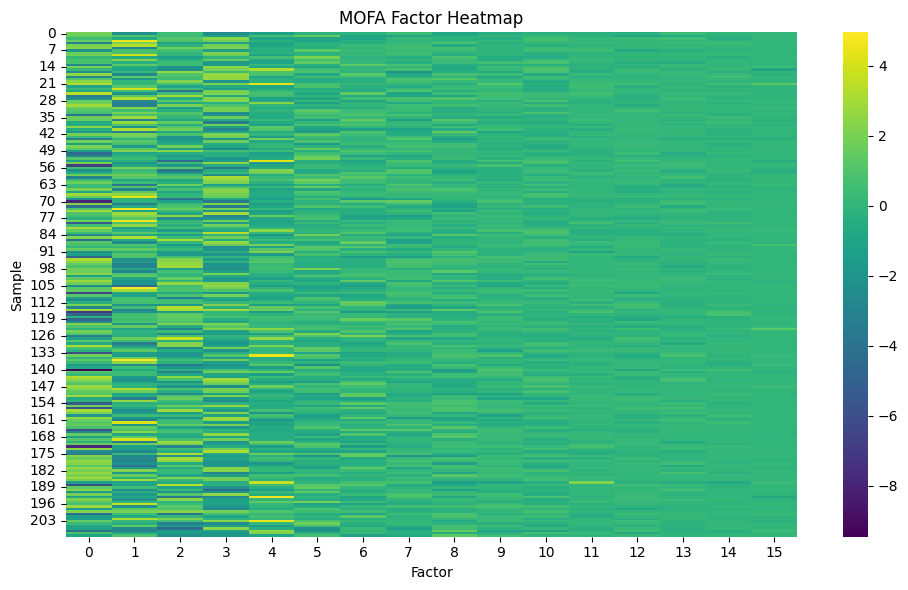

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# factors is already (n_samples × n_factors)
factor_array = np.array(factors)

# If you ever had only one sample, this ensures it's 2D
if factor_array.ndim == 1:
    factor_array = factor_array.reshape(1, -1)

plt.figure(figsize=(10, 6))
sns.heatmap(factor_array, cmap='viridis', annot=False)
plt.xlabel('Factor')
plt.ylabel('Sample')
plt.title('MOFA Factor Heatmap')
plt.tight_layout()
plt.show()


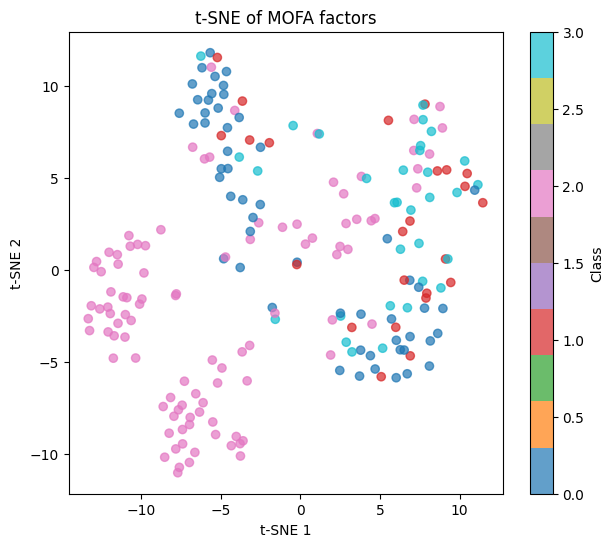

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
factors_2d = tsne.fit_transform(factors)

plt.figure(figsize=(7,6))
plt.scatter(factors_2d[:,0], factors_2d[:,1], c=subtype_encoded.values, cmap="tab10", alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE of MOFA factors")
plt.colorbar(label="Class")
plt.show()


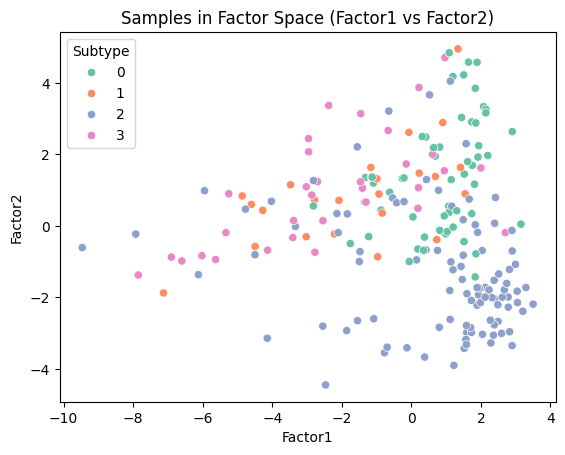

In [13]:
import seaborn as sns
factors_df = pd.DataFrame(factors, index=common_samples,
                          columns=[f"Factor{i+1}" for i in range(factors.shape[1])])
factors_df["Subtype"] = subtype_encoded.values

sns.scatterplot(data=factors_df, x="Factor1", y="Factor2", hue="Subtype", palette="Set2")
plt.title("Samples in Factor Space (Factor1 vs Factor2)")
plt.show()


In [14]:
import numpy as np

# Get factor matrix (samples × factors)
factors = ent.model.nodes["Z"].getExpectation()

# Compute L2 norm of each factor across samples
factor_norms = np.linalg.norm(factors, axis=0)

print("Factor norms:", factor_norms)
active_factors = np.sum(factor_norms > 1e-2)  # threshold can be adjusted
print(f"Active factors: {active_factors} / {factors.shape[1]}")


Factor norms: [37.19542875 29.54738544 24.37088997 26.91412979 17.96565758 12.78522295
 10.66180629  9.16615238  9.12097971  6.03397552  6.249876    4.27913803
  4.34272578  3.82831989  2.9786343   2.83658787]
Active factors: 16 / 16


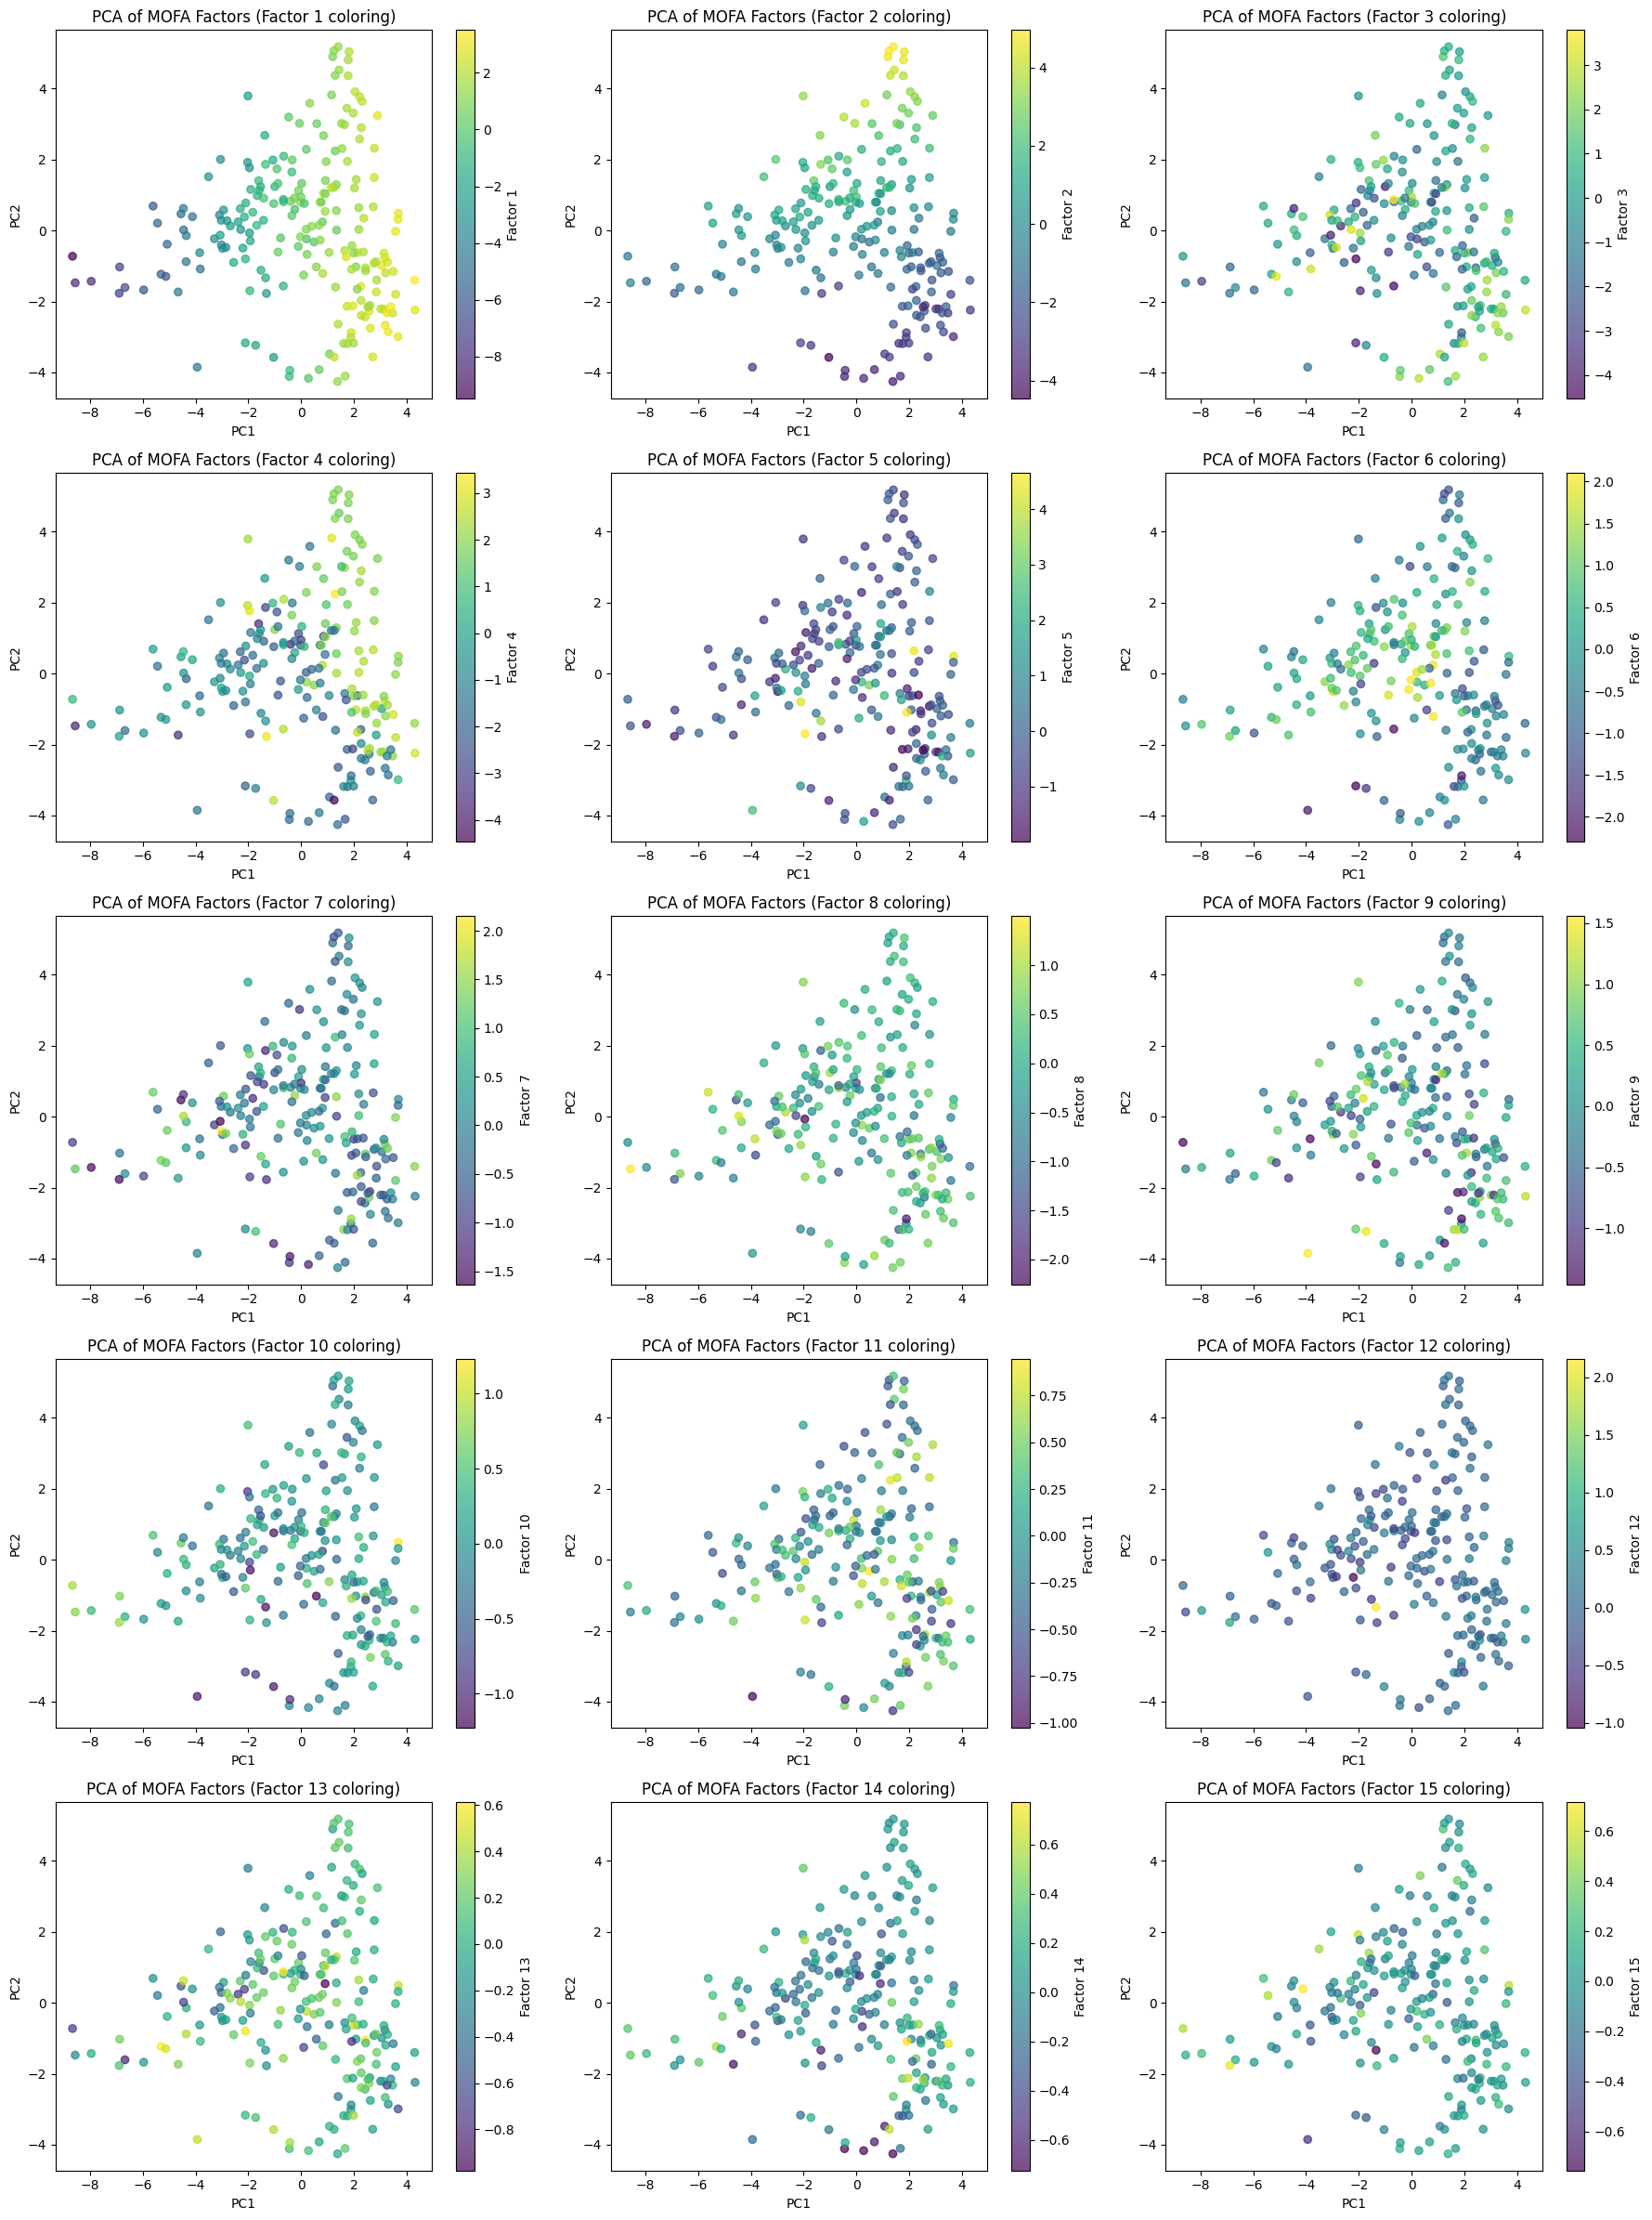

In [15]:
# PCA plots for all 15 MOFA factors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# factors: (n_samples, n_factors)
factors_array = np.array(factors)
labels = subtype_encoded.loc[common_samples].values

pca = PCA(n_components=2)

fig, axes = plt.subplots(5, 3, figsize=(18, 24))
axes = axes.flatten()

for i in range(15):
    # For each factor, use all factors for PCA, but color by the i-th factor
    pca_result = pca.fit_transform(factors_array)
    ax = axes[i]
    scatter = ax.scatter(pca_result[:,0], pca_result[:,1], c=factors_array[:,i], cmap='viridis', alpha=0.7)
    ax.set_title(f'PCA of MOFA Factors (Factor {i+1} coloring)')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    plt.colorbar(scatter, ax=ax, label=f'Factor {i+1}')

plt.tight_layout()
plt.show()

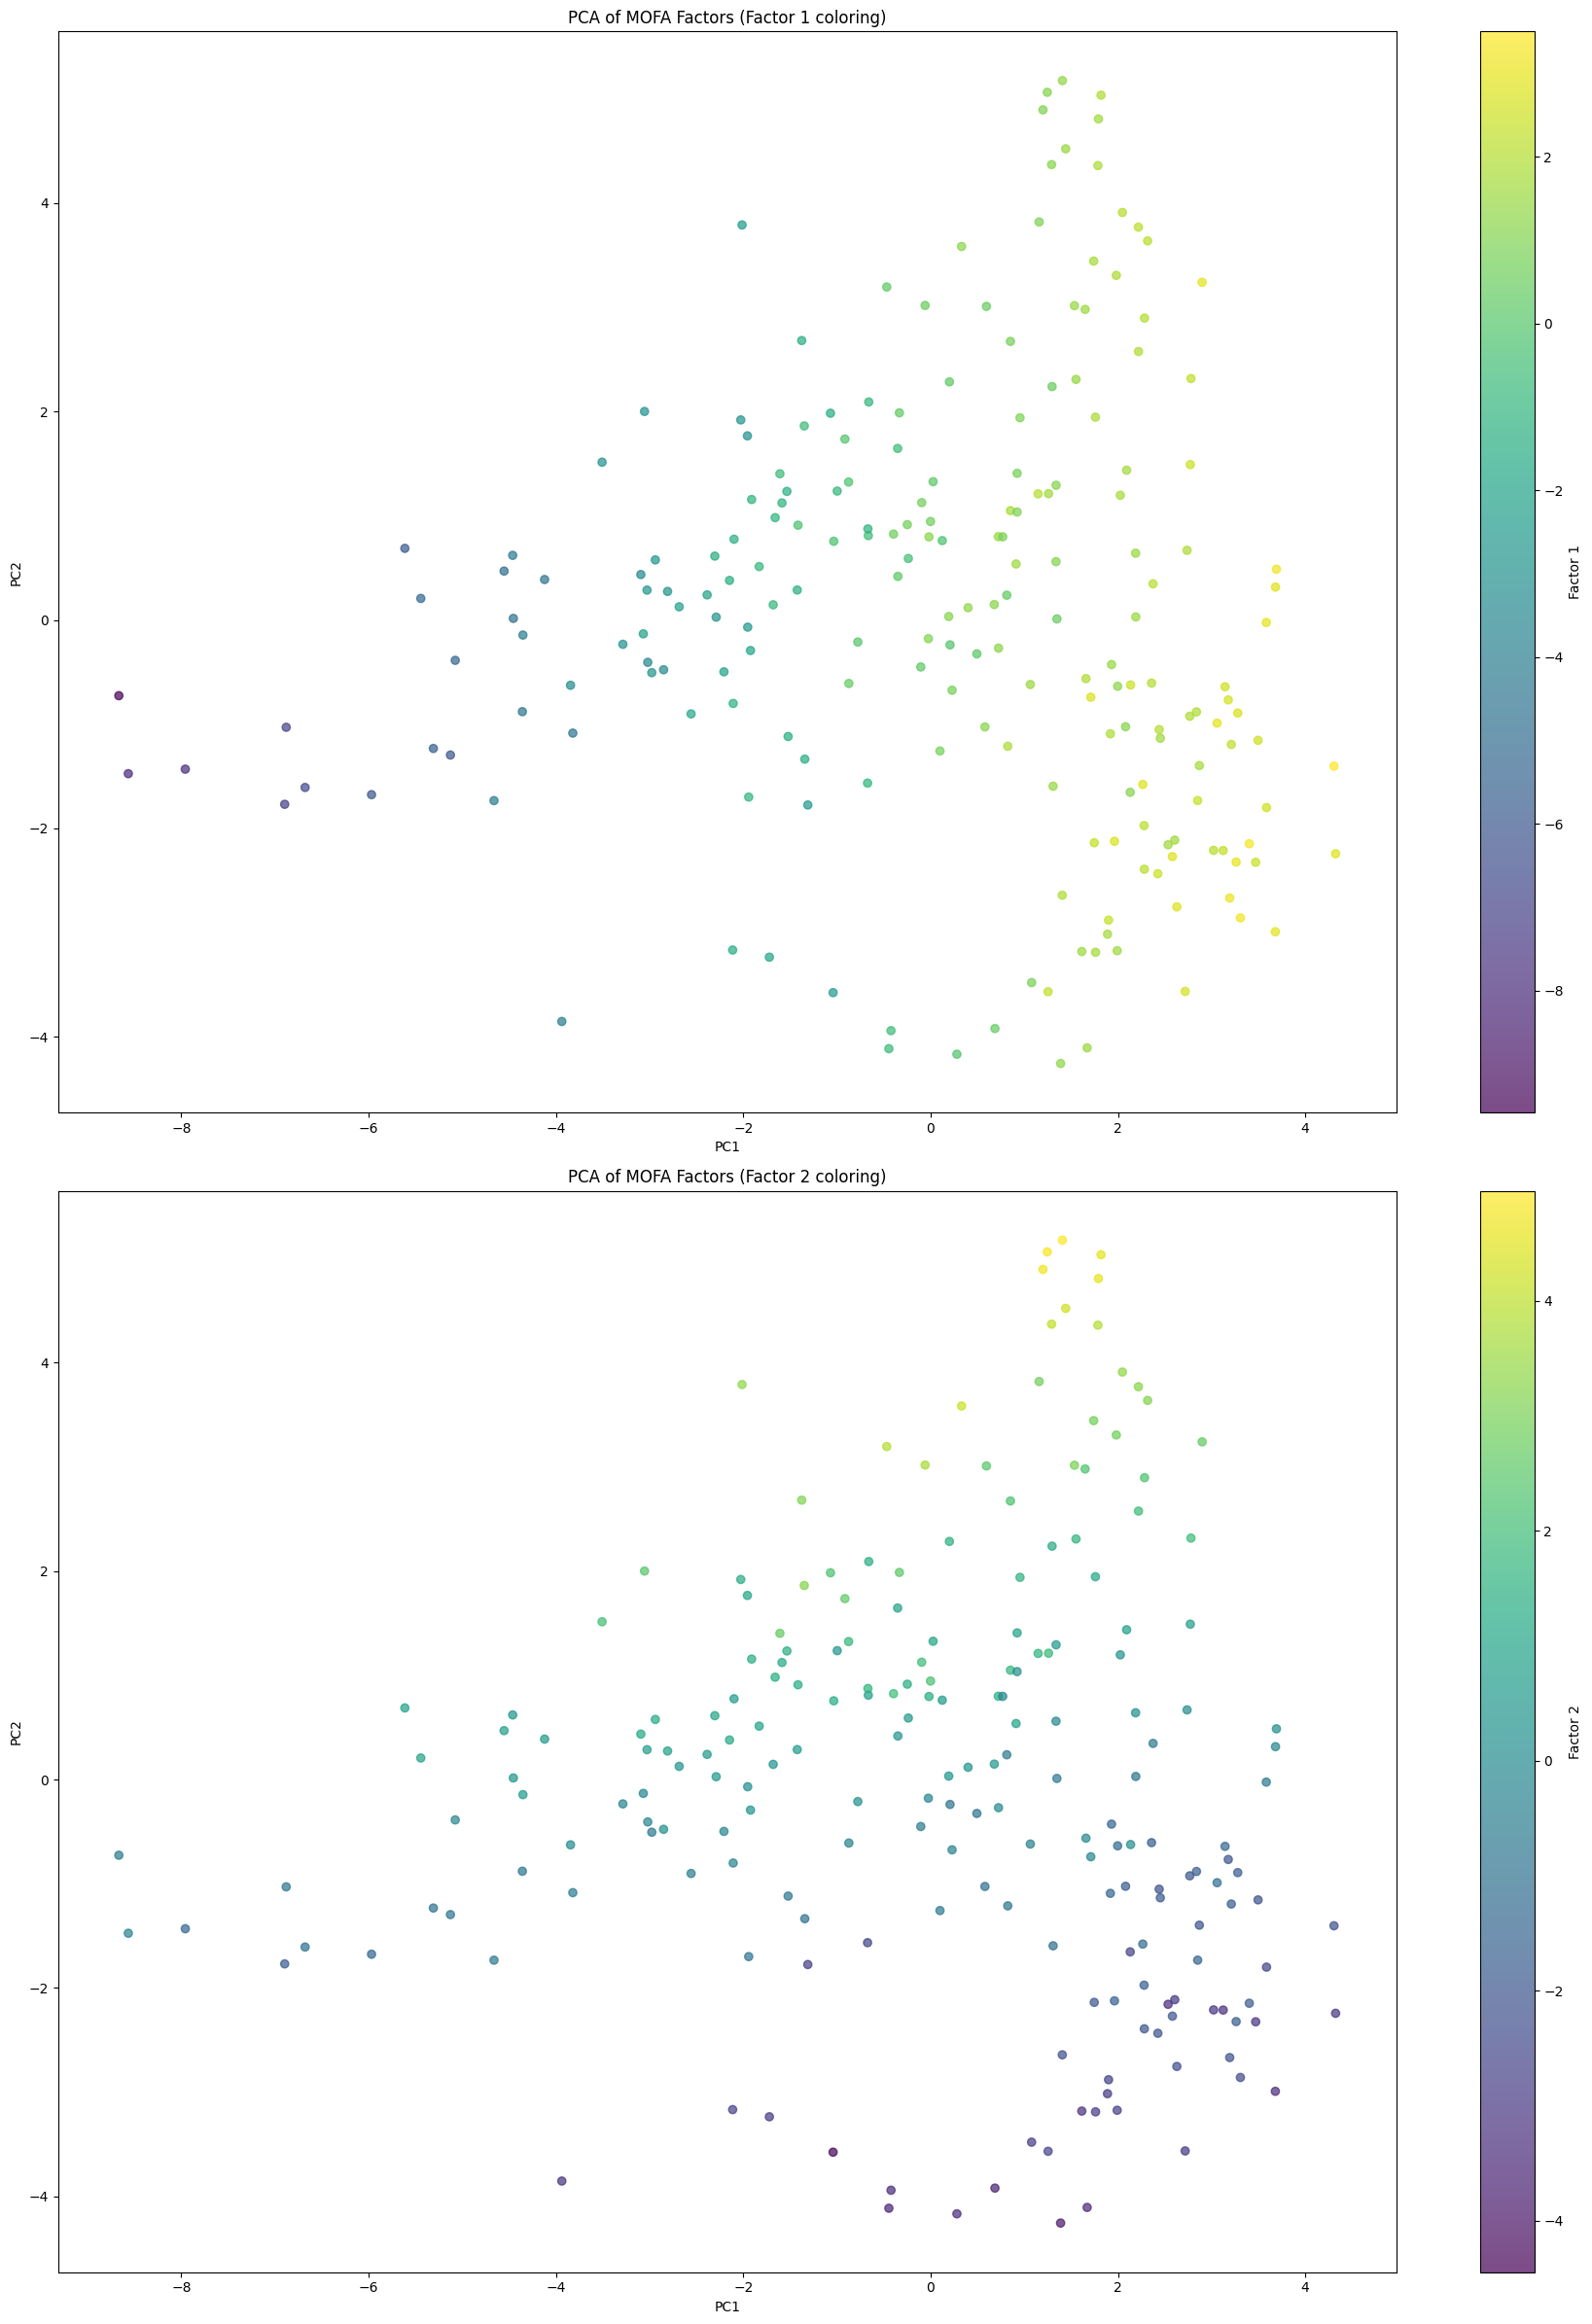

In [16]:
# PCA plots for all 15 MOFA factors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# factors: (n_samples, n_factors)
factors_array = np.array(factors)
labels = subtype_encoded.loc[common_samples].values

pca = PCA(n_components=2)

fig, axes = plt.subplots(2, 1, figsize=(18, 24))
axes = axes.flatten()

for i in range(2):
    # For each factor, use all factors for PCA, but color by the i-th factor
    pca_result = pca.fit_transform(factors_array)
    ax = axes[i]
    scatter = ax.scatter(pca_result[:,0], pca_result[:,1], c=factors_array[:,i], cmap='viridis', alpha=0.7)
    ax.set_title(f'PCA of MOFA Factors (Factor {i+1} coloring)')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    plt.colorbar(scatter, ax=ax, label=f'Factor {i+1}')

plt.tight_layout()
plt.show()

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Factors: samples × factors
X = np.array(factors)   # shape (177, 20)

# Labels: subtype-encoded
y = subtype_encoded.loc[common_samples].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression classifier
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)

# Predictions and accuracy
preds_lr = clf_lr.predict(X_test)
y_true_lr = y_test
acc_lr = accuracy_score(y_true_lr, preds_lr)
y_pred_proba_lr = clf_lr.predict_proba(X_test)
print('Logistic Regression accuracy:', acc_lr)

Logistic Regression accuracy: 0.6428571428571429


In [18]:
# 2. Random Forest on MOFA factors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)
preds_rf = clf_rf.predict(X_test)
y_true_rf = y_test
acc_rf = accuracy_score(y_true_rf, preds_rf)
y_pred_proba_rf = clf_rf.predict_proba(X_test)
print('Random Forest accuracy:', acc_rf)

Random Forest accuracy: 0.6666666666666666


In [19]:
# 3. Support Vector Machine (SVM) on MOFA factors
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_svm = SVC(kernel='rbf', probability=True, random_state=42)
clf_svm.fit(X_train, y_train)
preds_svm = clf_svm.predict(X_test)
y_true_svm = y_test
acc_svm = accuracy_score(y_true_svm, preds_svm)
y_pred_proba_svm = clf_svm.predict_proba(X_test)
print('SVM accuracy:', acc_svm)

SVM accuracy: 0.6666666666666666


In [20]:
# 4. K-Nearest Neighbors (KNN) on MOFA factors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_train, y_train)
preds_knn = clf_knn.predict(X_test)
y_true_knn = y_test
acc_knn = accuracy_score(y_true_knn, preds_knn)
y_pred_proba_knn = clf_knn.predict_proba(X_test)
print('KNN accuracy:', acc_knn)

KNN accuracy: 0.5714285714285714


In [21]:
# 5. Gradient Boosting (XGBoost) on MOFA factors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
try:
    from xgboost import XGBClassifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    clf_xgb.fit(X_train, y_train)
    preds_xgb = clf_xgb.predict(X_test)
    y_true_xgb = y_test
    acc_xgb = accuracy_score(y_true_xgb, preds_xgb)
    y_pred_proba_xgb = clf_xgb.predict_proba(X_test)
    print('XGBoost accuracy:', acc_xgb)
except ImportError:
    print('XGBoost is not installed. Please install xgboost to use this model.')

XGBoost accuracy: 0.6190476190476191


In [22]:
# 6. Naive Bayes on MOFA factors
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)
preds_nb = clf_nb.predict(X_test)
y_true_nb = y_test
acc_nb = accuracy_score(y_true_nb, preds_nb)
y_pred_proba_nb = clf_nb.predict_proba(X_test)
print('Naive Bayes accuracy:', acc_nb)

Naive Bayes accuracy: 0.5714285714285714


In [23]:
# Compare all 6 classifiers on MOFA factors: accuracy, F1 (macro/micro), precision, recall
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import pandas as pd

results = []
results.append(["Logistic Regression", acc_lr, f1_score(y_true_lr, preds_lr, average='macro'), f1_score(y_true_lr, preds_lr, average='micro'), precision_score(y_true_lr, preds_lr, average='macro', zero_division=0), precision_score(y_true_lr, preds_lr, average='micro', zero_division=0), recall_score(y_true_lr, preds_lr, average='macro'), recall_score(y_true_lr, preds_lr, average='micro')])
results.append(["Random Forest", acc_rf, f1_score(y_true_rf, preds_rf, average='macro'), f1_score(y_true_rf, preds_rf, average='micro'), precision_score(y_true_rf, preds_rf, average='macro', zero_division=0), precision_score(y_true_rf, preds_rf, average='micro', zero_division=0), recall_score(y_true_rf, preds_rf, average='macro'), recall_score(y_true_rf, preds_rf, average='micro')])
results.append(["SVM", acc_svm, f1_score(y_true_svm, preds_svm, average='macro'), f1_score(y_true_svm, preds_svm, average='micro'), precision_score(y_true_svm, preds_svm, average='macro', zero_division=0), precision_score(y_true_svm, preds_svm, average='micro', zero_division=0), recall_score(y_true_svm, preds_svm, average='macro'), recall_score(y_true_svm, preds_svm, average='micro')])
results.append(["KNN", acc_knn, f1_score(y_true_knn, preds_knn, average='macro'), f1_score(y_true_knn, preds_knn, average='micro'), precision_score(y_true_knn, preds_knn, average='macro', zero_division=0), precision_score(y_true_knn, preds_knn, average='micro', zero_division=0), recall_score(y_true_knn, preds_knn, average='macro'), recall_score(y_true_knn, preds_knn, average='micro')])
try:
    results.append(["XGBoost", acc_xgb, f1_score(y_true_xgb, preds_xgb, average='macro'), f1_score(y_true_xgb, preds_xgb, average='micro'), precision_score(y_true_xgb, preds_xgb, average='macro', zero_division=0), precision_score(y_true_xgb, preds_xgb, average='micro', zero_division=0), recall_score(y_true_xgb, preds_xgb, average='macro'), recall_score(y_true_xgb, preds_xgb, average='micro')])
except:
    pass
results.append(["Naive Bayes", acc_nb, f1_score(y_true_nb, preds_nb, average='macro'), f1_score(y_true_nb, preds_nb, average='micro'), precision_score(y_true_nb, preds_nb, average='macro', zero_division=0), precision_score(y_true_nb, preds_nb, average='micro', zero_division=0), recall_score(y_true_nb, preds_nb, average='macro'), recall_score(y_true_nb, preds_nb, average='micro')])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Macro", "F1 Micro", "Precision Macro", "Precision Micro", "Recall Macro", "Recall Micro"])
print(results_df.round(3))

                 Model  Accuracy  F1 Macro  F1 Micro  Precision Macro  \
0  Logistic Regression     0.643     0.487     0.643            0.472   
1        Random Forest     0.667     0.563     0.667            0.582   
2                  SVM     0.667     0.503     0.667            0.489   
3                  KNN     0.571     0.418     0.571            0.442   
4              XGBoost     0.619     0.504     0.619            0.524   
5          Naive Bayes     0.571     0.499     0.571            0.526   

   Precision Micro  Recall Macro  Recall Micro  
0            0.643         0.507         0.643  
1            0.667         0.567         0.667  
2            0.667         0.569         0.667  
3            0.571         0.461         0.571  
4            0.619         0.503         0.619  
5            0.571         0.545         0.571  


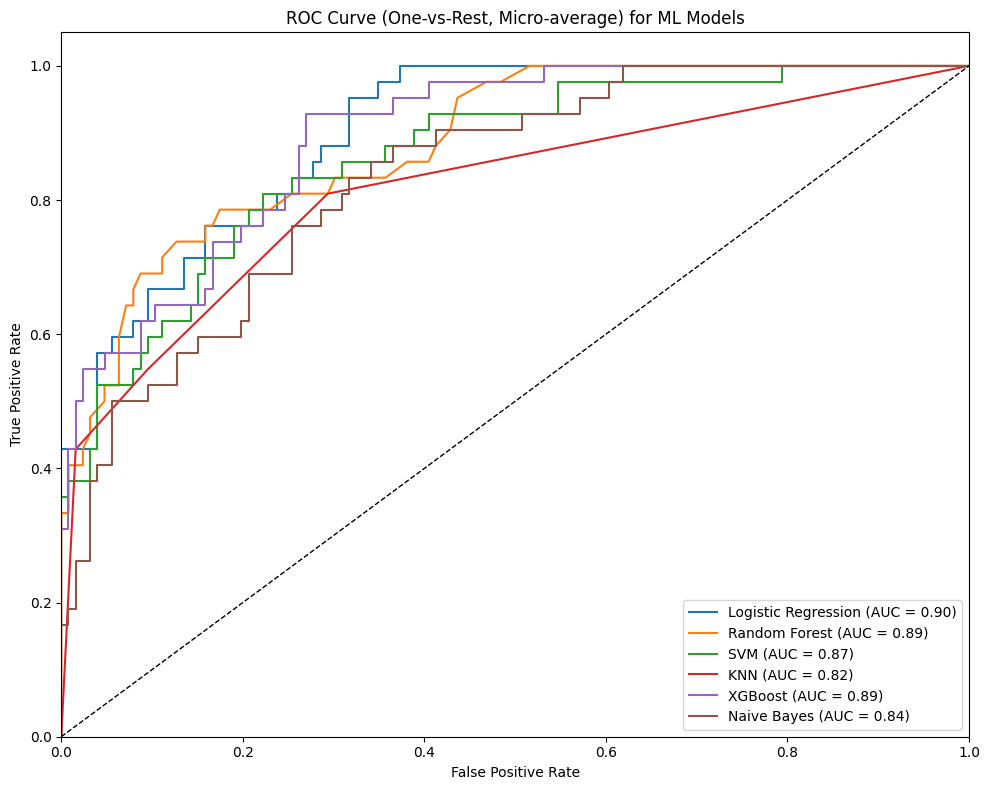

In [24]:
# Plot ROC curves and compute AUC for all ML models (multiclass one-vs-rest)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import numpy as np

# List of models and their predicted probabilities
models = [
    ('Logistic Regression', y_pred_proba_lr, y_true_lr),
    ('Random Forest', y_pred_proba_rf, y_true_rf),
    ('SVM', y_pred_proba_svm, y_true_svm),
    ('KNN', y_pred_proba_knn, y_true_knn),
    ('XGBoost', y_pred_proba_xgb, y_true_xgb),
    ('Naive Bayes', y_pred_proba_nb, y_true_nb)
 ]

plt.figure(figsize=(10, 8))
for name, y_pred_proba, y_true in models:
    try:
        classes = np.unique(y_true)
        y_test_bin = label_binarize(y_true, classes=classes)
        n_classes = y_test_bin.shape[1]
        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute micro-average ROC curve and AUC
        fpr['micro'], tpr['micro'], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
        roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
        plt.plot(fpr['micro'], tpr['micro'], label=f'{name} (AUC = {roc_auc["micro"]:.2f})')
    except Exception as e:
        print(f"Could not plot ROC for {name}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest, Micro-average) for ML Models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [25]:
# Prepare data (expects `factors` and `subtype_encoded` to exist from earlier cells)
X = np.array(factors)
y = subtype_encoded.loc[common_samples].values

# Split: train+val / test, then carve out validation from train
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

In [26]:
class ShallowMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x

input_dim = X_train.shape[1]
hidden_dim = 64
num_classes = len(np.unique(y))

model = ShallowMLP(input_dim, hidden_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Early stopping settings
patience = 5
best_val_loss = float('inf')
patience_counter = 0
best_state = None

n_epochs = 100
batch_size = 16

# Simple batch training without DataLoader to keep the cell compact
num_train = X_train_t.size(0)
indices = np.arange(num_train)

for epoch in range(1, n_epochs+1):
    # --- training ---
    model.train()
    # shuffle
    np.random.shuffle(indices)
    train_loss = 0.0
    for start in range(0, num_train, batch_size):
        batch_idx = indices[start:start+batch_size]
        xb = X_train_t[batch_idx]
        yb = y_train_t[batch_idx]
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= num_train

    # --- validation ---
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_t)
        val_loss = criterion(val_outputs, y_val_t).item()

    print(f"Epoch {epoch:03d} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")

    # check early stopping (val loss improvement)
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        patience_counter = 0
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch} (no improvement for {patience} epochs)")
            break

# load best model state (if saved)
if best_state is not None:
    model.load_state_dict(best_state)

# Evaluate on test set
model.eval()
with torch.no_grad():
    logits_shallow = model(X_test_t)
    preds_shallow = logits_shallow.argmax(dim=1).cpu().numpy()
    y_true_shallow = y_test_t.cpu().numpy()

acc_shallow = accuracy_score(y_true_shallow, preds_shallow)
f1_shallow = f1_score(y_true_shallow, preds_shallow, average='macro')
print(f"\nTest Accuracy: {acc_shallow:.4f} | Test F1 (macro): {f1_shallow:.4f}")
# End of shallow MLP cell

Epoch 001 | Train loss: 1.3914 | Val loss: 1.3234
Epoch 002 | Train loss: 1.2758 | Val loss: 1.2377
Epoch 003 | Train loss: 1.1887 | Val loss: 1.1583
Epoch 004 | Train loss: 1.1072 | Val loss: 1.0943
Epoch 005 | Train loss: 1.0398 | Val loss: 1.0423
Epoch 006 | Train loss: 0.9780 | Val loss: 0.9978
Epoch 007 | Train loss: 0.9250 | Val loss: 0.9583
Epoch 008 | Train loss: 0.8777 | Val loss: 0.9268
Epoch 009 | Train loss: 0.8381 | Val loss: 0.8999
Epoch 010 | Train loss: 0.8038 | Val loss: 0.8779
Epoch 011 | Train loss: 0.7721 | Val loss: 0.8570
Epoch 012 | Train loss: 0.7440 | Val loss: 0.8393
Epoch 013 | Train loss: 0.7199 | Val loss: 0.8253
Epoch 014 | Train loss: 0.6984 | Val loss: 0.8112
Epoch 015 | Train loss: 0.6785 | Val loss: 0.7988
Epoch 016 | Train loss: 0.6610 | Val loss: 0.7876
Epoch 017 | Train loss: 0.6430 | Val loss: 0.7769
Epoch 018 | Train loss: 0.6279 | Val loss: 0.7656
Epoch 019 | Train loss: 0.6122 | Val loss: 0.7574
Epoch 020 | Train loss: 0.5974 | Val loss: 0.7462


In [27]:
class DeepMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y))
model = DeepMLP(input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Early stopping
patience = 5
best_val_loss = float('inf')
patience_counter = 0
best_state = None

n_epochs = 100
batch_size = 16
num_train = X_train_t.size(0)
indices = np.arange(num_train)

for epoch in range(1, n_epochs+1):
    model.train()
    np.random.shuffle(indices)
    train_loss = 0.0
    for start in range(0, num_train, batch_size):
        batch_idx = indices[start:start+batch_size]
        xb = X_train_t[batch_idx]
        yb = y_train_t[batch_idx]
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= num_train

    model.eval()
    with torch.no_grad():
        val_out = model(X_val_t)
        val_loss = criterion(val_out, y_val_t).item()

    print(f"[DeepMLP] Epoch {epoch:03d} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")

    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        patience_counter = 0
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"[DeepMLP] Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
            break

if best_state is not None:
    model.load_state_dict(best_state)

model.eval()
with torch.no_grad():
    logits_deep = model(X_test_t)
    preds_deep = logits_deep.argmax(dim=1).cpu().numpy()
    y_true_deep = y_test_t.cpu().numpy()

acc_deep = accuracy_score(y_true_deep, preds_deep)
macrof1_deep = f1_score(y_true_deep, preds_deep, average='macro')
print(f"[DeepMLP] Test Accuracy: {acc_deep:.4f} | Test F1 (macro): {macrof1_deep:.4f}")

[DeepMLP] Epoch 001 | Train loss: 1.3281 | Val loss: 1.1669
[DeepMLP] Epoch 002 | Train loss: 1.0968 | Val loss: 0.9417
[DeepMLP] Epoch 003 | Train loss: 0.8900 | Val loss: 0.8010
[DeepMLP] Epoch 004 | Train loss: 0.7497 | Val loss: 0.7464
[DeepMLP] Epoch 005 | Train loss: 0.6919 | Val loss: 0.7084
[DeepMLP] Epoch 006 | Train loss: 0.6057 | Val loss: 0.6876
[DeepMLP] Epoch 007 | Train loss: 0.5656 | Val loss: 0.6724
[DeepMLP] Epoch 008 | Train loss: 0.5248 | Val loss: 0.6607
[DeepMLP] Epoch 009 | Train loss: 0.4873 | Val loss: 0.6538
[DeepMLP] Epoch 010 | Train loss: 0.5125 | Val loss: 0.6480
[DeepMLP] Epoch 011 | Train loss: 0.4492 | Val loss: 0.6245
[DeepMLP] Epoch 012 | Train loss: 0.4376 | Val loss: 0.6115
[DeepMLP] Epoch 013 | Train loss: 0.4144 | Val loss: 0.6708
[DeepMLP] Epoch 014 | Train loss: 0.4317 | Val loss: 0.6845
[DeepMLP] Epoch 015 | Train loss: 0.3638 | Val loss: 0.6965
[DeepMLP] Epoch 016 | Train loss: 0.3584 | Val loss: 0.6970
[DeepMLP] Epoch 017 | Train loss: 0.3306

In [28]:
input_dim = X_train.shape[1]
latent_dim = 16
num_classes = len(np.unique(y))

# Autoencoder
class AE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z

# Pretrain autoencoder
ae = AE(input_dim, latent_dim).to(device)
recon_criterion = nn.MSELoss()
optimizer_ae = optim.Adam(ae.parameters(), lr=1e-3)

n_epochs_ae = 50
batch_size = 16
num_train = X_train_t.size(0)
indices = np.arange(num_train)

print('[AE] Pretraining autoencoder...')
for epoch in range(1, n_epochs_ae+1):
    ae.train()
    np.random.shuffle(indices)
    epoch_loss = 0.0
    for start in range(0, num_train, batch_size):
        batch_idx = indices[start:start+batch_size]
        xb = X_train_t[batch_idx]
        optimizer_ae.zero_grad()
        recon, _ = ae(xb)
        loss = recon_criterion(recon, xb)
        loss.backward()
        optimizer_ae.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= num_train
    if epoch % 10 == 0 or epoch==1:
        print(f"[AE] Epoch {epoch:03d} | Recon loss: {epoch_loss:.6f}")

# Build classifier on top of encoder
class AEClassifier(nn.Module):
    def __init__(self, encoder, latent_dim, num_classes):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        with torch.no_grad():
            z = self.encoder(x)
        # allow classifier params to be trained
        return self.classifier(z)

clf = AEClassifier(ae.encoder, latent_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.classifier.parameters(), lr=1e-3)

# Early stopping for classifier
patience = 5
best_val_loss = float('inf')
patience_counter = 0
best_state = None

n_epochs = 100
num_train = X_train_t.size(0)
indices = np.arange(num_train)

for epoch in range(1, n_epochs+1):
    clf.train()
    np.random.shuffle(indices)
    train_loss = 0.0
    for start in range(0, num_train, batch_size):
        batch_idx = indices[start:start+batch_size]
        xb = X_train_t[batch_idx]
        yb = y_train_t[batch_idx]
        optimizer.zero_grad()
        out = clf(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= num_train

    clf.eval()
    with torch.no_grad():
        val_out = clf(X_val_t)
        val_loss = criterion(val_out, y_val_t).item()

    print(f"[AE-CLF] Epoch {epoch:03d} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")

    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        patience_counter = 0
        best_state = {k: v.cpu().clone() for k, v in clf.state_dict().items()}
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"[AE-CLF] Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
            break

if best_state is not None:
    clf.load_state_dict(best_state)

clf.eval()
with torch.no_grad():
    logits_ae = clf(X_test_t)
    preds_ae = logits_ae.argmax(dim=1).cpu().numpy()
    y_true_ae = y_test_t.cpu().numpy()

acc_ae = accuracy_score(y_true_ae, preds_ae)
macrof1_ae = f1_score(y_true_ae, preds_ae, average='macro')
print(f"[AE-CLF] Test Accuracy: {acc_ae:.4f} | Test F1 (macro): {macrof1_ae:.4f}")

[AE] Pretraining autoencoder...
[AE] Epoch 001 | Recon loss: 1.323964
[AE] Epoch 010 | Recon loss: 0.193711
[AE] Epoch 020 | Recon loss: 0.078218
[AE] Epoch 030 | Recon loss: 0.038358
[AE] Epoch 040 | Recon loss: 0.027354
[AE] Epoch 050 | Recon loss: 0.020973
[AE-CLF] Epoch 001 | Train loss: 1.3264 | Val loss: 1.2767
[AE-CLF] Epoch 002 | Train loss: 1.2388 | Val loss: 1.1973
[AE-CLF] Epoch 003 | Train loss: 1.1586 | Val loss: 1.1325
[AE-CLF] Epoch 004 | Train loss: 1.0942 | Val loss: 1.0707
[AE-CLF] Epoch 005 | Train loss: 1.0280 | Val loss: 1.0200
[AE-CLF] Epoch 006 | Train loss: 0.9716 | Val loss: 0.9724
[AE-CLF] Epoch 007 | Train loss: 0.9192 | Val loss: 0.9298
[AE-CLF] Epoch 008 | Train loss: 0.8740 | Val loss: 0.8953
[AE-CLF] Epoch 009 | Train loss: 0.8314 | Val loss: 0.8645
[AE-CLF] Epoch 010 | Train loss: 0.7949 | Val loss: 0.8379
[AE-CLF] Epoch 011 | Train loss: 0.7633 | Val loss: 0.8117
[AE-CLF] Epoch 012 | Train loss: 0.7358 | Val loss: 0.7918
[AE-CLF] Epoch 013 | Train loss:

In [29]:
try:
    from torch_geometric.nn import knn_graph
    use_tg_knn = True
except Exception:
    use_tg_knn = False

# We'll create train/val/test node masks
n_nodes = X.shape[0]
train_idx, test_idx = train_test_split(np.arange(n_nodes), test_size=0.2, random_state=42, stratify=y)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=42, stratify=y[train_idx])

# Create edges via kNN on factor space (k=8)
k = 8
if use_tg_knn:
    edge_index = knn_graph(torch.tensor(X, dtype=torch.float32), k=k)
else:
    # fallback: compute via sklearn NearestNeighbors
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    # build edge index (exclude self-loop first column)
    src = np.repeat(np.arange(n_nodes), k)
    dst = indices[:, 1:(k+1)].reshape(-1)
    edge_index = torch.tensor([src, dst], dtype=torch.long)

# Build PyG data object
x = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.long)
mask_train = torch.zeros(n_nodes, dtype=torch.bool)
mask_val = torch.zeros(n_nodes, dtype=torch.bool)
mask_test = torch.zeros(n_nodes, dtype=torch.bool)
mask_train[train_idx] = True
mask_val[val_idx] = True
mask_test[test_idx] = True

data = Data(x=x, edge_index=edge_index, y=y_t)

# GAT model
class GATNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=4, dropout=0.3)
        self.conv2 = GATConv(hidden_channels*4, out_channels, heads=1, concat=False, dropout=0.3)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATNet(X.shape[1], 32, len(np.unique(y))).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

data = data.to(device)

# Early stopping
patience = 5
best_val_loss = float('inf')
patience_counter = 0
best_state = None

n_epochs = 200
for epoch in range(1, n_epochs+1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[mask_train], data.y[mask_train])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_out = model(data.x, data.edge_index)
        val_loss = criterion(val_out[mask_val], data.y[mask_val]).item()

    if epoch % 10 == 0:
        print(f"[GAT] Epoch {epoch:03d} | Train loss: {loss.item():.4f} | Val loss: {val_loss:.4f}")

    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        patience_counter = 0
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"[GAT] Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
            break

if best_state is not None:
    model.load_state_dict(best_state)

model.eval()
with torch.no_grad():
    logits_gat = model(data.x, data.edge_index)
    preds_gat = logits_gat[mask_test].argmax(dim=1).cpu().numpy()
    y_true_gat = data.y[mask_test].cpu().numpy()

acc_gat = accuracy_score(y_true_gat, preds_gat)
macrof1_gat = f1_score(y_true_gat, preds_gat, average='macro')
print(f"[GAT] Test Accuracy: {acc_gat:.4f} | Test F1 (macro): {macrof1_gat:.4f}")

[GAT] Epoch 010 | Train loss: 1.1323 | Val loss: 1.1659
[GAT] Epoch 020 | Train loss: 0.9537 | Val loss: 0.9814
[GAT] Epoch 030 | Train loss: 0.8378 | Val loss: 0.8865
[GAT] Epoch 040 | Train loss: 0.7945 | Val loss: 0.8316
[GAT] Epoch 050 | Train loss: 0.7569 | Val loss: 0.7925
[GAT] Epoch 060 | Train loss: 0.7643 | Val loss: 0.7628
[GAT] Epoch 070 | Train loss: 0.7392 | Val loss: 0.7392
[GAT] Epoch 080 | Train loss: 0.6819 | Val loss: 0.7279
[GAT] Epoch 090 | Train loss: 0.7057 | Val loss: 0.7224
[GAT] Epoch 100 | Train loss: 0.6695 | Val loss: 0.7213
[GAT] Early stopping at epoch 100 (no improvement for 5 epochs)
[GAT] Test Accuracy: 0.5476 | Test F1 (macro): 0.3738


In [30]:
try:
    from torch_geometric.nn import knn_graph
    edge_index = knn_graph(torch.tensor(X, dtype=torch.float32), k=k)
except Exception:
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    src = np.repeat(np.arange(n_nodes), k)
    dst = indices[:, 1:(k+1)].reshape(-1)
    edge_index = torch.tensor([src, dst], dtype=torch.long)

x = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.long)
mask_train = torch.zeros(n_nodes, dtype=torch.bool)
mask_val = torch.zeros(n_nodes, dtype=torch.bool)
mask_test = torch.zeros(n_nodes, dtype=torch.bool)
mask_train[train_idx] = True
mask_val[val_idx] = True
mask_test[test_idx] = True

data = Data(x=x, edge_index=edge_index, y=y_t)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GCNNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GCNNet(X.shape[1], 64, len(np.unique(y))).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

data = data.to(device)

# Early stopping
patience = 5
best_val_loss = float('inf')
patience_counter = 0
best_state = None

n_epochs = 200
for epoch in range(1, n_epochs+1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[mask_train], data.y[mask_train])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_out = model(data.x, data.edge_index)
        val_loss = criterion(val_out[mask_val], data.y[mask_val]).item()

    if epoch % 10 == 0:
        print(f"[GCN] Epoch {epoch:03d} | Train loss: {loss.item():.4f} | Val loss: {val_loss:.4f}")

    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        patience_counter = 0
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"[GCN] Early stopping at epoch {epoch} (no improvement for {patience} epochs)")
            break

if best_state is not None:
    model.load_state_dict(best_state)

model.eval()
with torch.no_grad():
    logits_gcn = model(data.x, data.edge_index)
    preds_gcn = logits_gcn[mask_test].argmax(dim=1).cpu().numpy()
    y_true_gcn = data.y[mask_test].cpu().numpy()

acc_gcn = accuracy_score(y_true_gcn, preds_gcn)
macrof1_gcn = f1_score(y_true_gcn, preds_gcn, average='macro')
print(f"[GCN] Test Accuracy: {acc_gcn:.4f} | Test F1 (macro): {macrof1_gcn:.4f}")

[GCN] Epoch 010 | Train loss: 1.4976 | Val loss: 1.5107
[GCN] Epoch 020 | Train loss: 1.2532 | Val loss: 1.2796
[GCN] Epoch 030 | Train loss: 1.0728 | Val loss: 1.1152
[GCN] Epoch 040 | Train loss: 0.9486 | Val loss: 1.0067
[GCN] Epoch 050 | Train loss: 0.8671 | Val loss: 0.9378
[GCN] Epoch 060 | Train loss: 0.8138 | Val loss: 0.8932
[GCN] Epoch 070 | Train loss: 0.7774 | Val loss: 0.8617
[GCN] Epoch 080 | Train loss: 0.7509 | Val loss: 0.8380
[GCN] Epoch 090 | Train loss: 0.7306 | Val loss: 0.8199
[GCN] Epoch 100 | Train loss: 0.7141 | Val loss: 0.8060
[GCN] Epoch 110 | Train loss: 0.7003 | Val loss: 0.7955
[GCN] Epoch 120 | Train loss: 0.6882 | Val loss: 0.7875
[GCN] Epoch 130 | Train loss: 0.6775 | Val loss: 0.7815
[GCN] Epoch 140 | Train loss: 0.6676 | Val loss: 0.7768
[GCN] Epoch 150 | Train loss: 0.6585 | Val loss: 0.7732
[GCN] Epoch 160 | Train loss: 0.6500 | Val loss: 0.7707
[GCN] Epoch 170 | Train loss: 0.6420 | Val loss: 0.7693
[GCN] Epoch 180 | Train loss: 0.6345 | Val loss:

In [31]:
# Compare results for all NN models: Shallow MLP, Deep MLP, AE, GAT, GCN
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

results = []
results.append([
    'Shallow MLP',
    accuracy_score(y_true_shallow, preds_shallow),
    f1_score(y_true_shallow, preds_shallow, average='macro'),
    f1_score(y_true_shallow, preds_shallow, average='micro'),
    precision_score(y_true_shallow, preds_shallow, average='macro', zero_division=0),
    precision_score(y_true_shallow, preds_shallow, average='micro', zero_division=0),
    recall_score(y_true_shallow, preds_shallow, average='macro'),
    recall_score(y_true_shallow, preds_shallow, average='micro')
 ])
results.append([
    'Deep MLP',
    accuracy_score(y_true_deep, preds_deep),
    f1_score(y_true_deep, preds_deep, average='macro'),
    f1_score(y_true_deep, preds_deep, average='micro'),
    precision_score(y_true_deep, preds_deep, average='macro', zero_division=0),
    precision_score(y_true_deep, preds_deep, average='micro', zero_division=0),
    recall_score(y_true_deep, preds_deep, average='macro'),
    recall_score(y_true_deep, preds_deep, average='micro')
 ])
results.append([
    'Autoencoder',
    accuracy_score(y_true_ae, preds_ae),
    f1_score(y_true_ae, preds_ae, average='macro'),
    f1_score(y_true_ae, preds_ae, average='micro'),
    precision_score(y_true_ae, preds_ae, average='macro', zero_division=0),
    precision_score(y_true_ae, preds_ae, average='micro', zero_division=0),
    recall_score(y_true_ae, preds_ae, average='macro'),
    recall_score(y_true_ae, preds_ae, average='micro')
 ])
results.append([
    'GAT',
    accuracy_score(y_true_gat, preds_gat),
    f1_score(y_true_gat, preds_gat, average='macro'),
    f1_score(y_true_gat, preds_gat, average='micro'),
    precision_score(y_true_gat, preds_gat, average='macro', zero_division=0),
    precision_score(y_true_gat, preds_gat, average='micro', zero_division=0),
    recall_score(y_true_gat, preds_gat, average='macro'),
    recall_score(y_true_gat, preds_gat, average='micro')
 ])
results.append([
    'GCN',
    accuracy_score(y_true_gcn, preds_gcn),
    f1_score(y_true_gcn, preds_gcn, average='macro'),
    f1_score(y_true_gcn, preds_gcn, average='micro'),
    precision_score(y_true_gcn, preds_gcn, average='macro', zero_division=0),
    precision_score(y_true_gcn, preds_gcn, average='micro', zero_division=0),
    recall_score(y_true_gcn, preds_gcn, average='macro'),
    recall_score(y_true_gcn, preds_gcn, average='micro')
 ])

results_df = pd.DataFrame(results, columns=[
    'Model', 'Accuracy', 'F1 Macro', 'F1 Micro', 'Precision Macro', 'Precision Micro', 'Recall Macro', 'Recall Micro'
 ])
print(results_df.round(3))

         Model  Accuracy  F1 Macro  F1 Micro  Precision Macro  \
0  Shallow MLP     0.667     0.494     0.667            0.468   
1     Deep MLP     0.619     0.453     0.619            0.428   
2  Autoencoder     0.643     0.458     0.643            0.441   
3          GAT     0.548     0.374     0.548            0.381   
4          GCN     0.619     0.532     0.619            0.708   

   Precision Micro  Recall Macro  Recall Micro  
0            0.667         0.530         0.667  
1            0.619         0.484         0.619  
2            0.643         0.488         0.643  
3            0.548         0.419         0.548  
4            0.619         0.552         0.619  


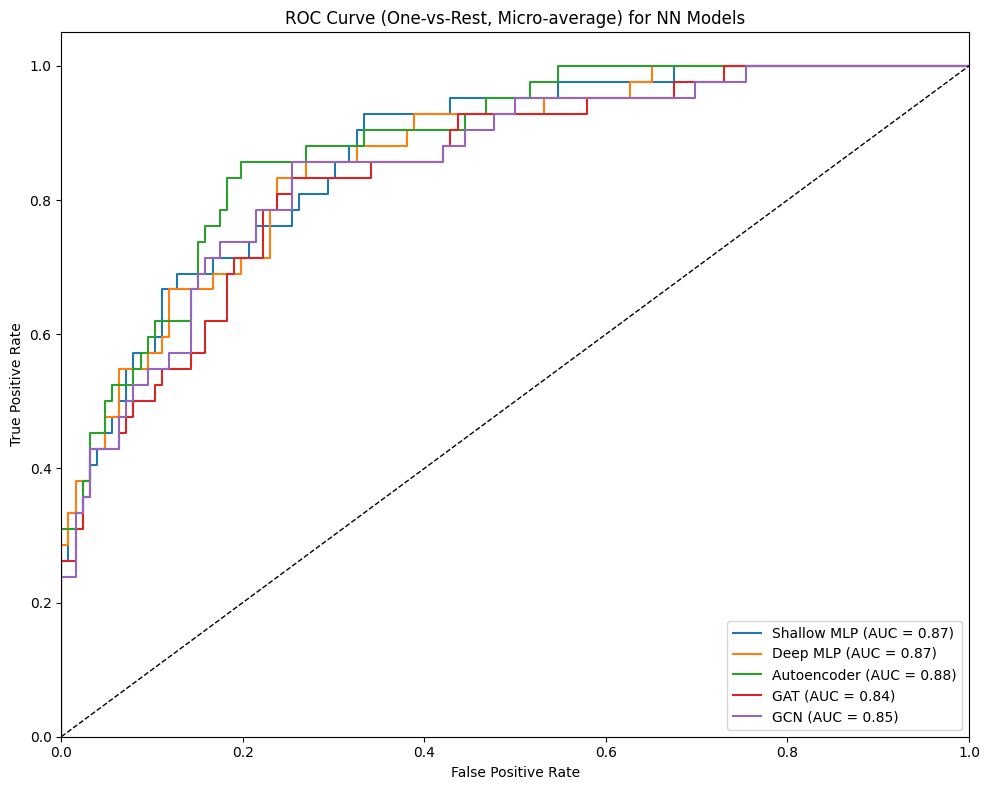

In [32]:
# Plot ROC curves and compute AUC for all NN models (multiclass one-vs-rest)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# List of NN models and their logits (before softmax) and true labels
nn_models = [
    ('Shallow MLP', logits_shallow, y_true_shallow),
    ('Deep MLP', logits_deep, y_true_deep),
    ('Autoencoder', logits_ae, y_true_ae),
    ('GAT', logits_gat[mask_test], y_true_gat),
    ('GCN', logits_gcn[mask_test], y_true_gcn)
 ]

plt.figure(figsize=(10, 8))
for name, logits, y_true in nn_models:
    try:
        # Convert logits to probabilities
        y_pred_proba = np.exp(logits.cpu().numpy())
        y_pred_proba = y_pred_proba / y_pred_proba.sum(axis=1, keepdims=True)
        classes = np.unique(y_true)
        y_test_bin = label_binarize(y_true, classes=classes)
        n_classes = y_test_bin.shape[1]
        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute micro-average ROC curve and AUC
        fpr['micro'], tpr['micro'], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
        roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
        plt.plot(fpr['micro'], tpr['micro'], label=f'{name} (AUC = {roc_auc["micro"]:.2f})')
    except Exception as e:
        print(f"Could not plot ROC for {name}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest, Micro-average) for NN Models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()